# imports

In [2]:
import findspark
findspark.init('D:\spark\spark-2.3.2-bin-hadoop2.7')

from pyspark.sql import *
from pyspark import SparkContext
from pyspark.mllib.regression import LabeledPoint
import numpy as np
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.tree import GradientBoostedTrees



# spark Session

In [3]:
spark = SparkSession.builder.getOrCreate()

df = spark.sql('''select 'spark' as hello ''')
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



# spark context for files

In [4]:
sc = SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Reading csv files

In [5]:
nycData = sc.textFile("nyc_rolling.csv")

In [8]:
data = nycData.map(lambda line: line.split(","))
data
line_1 = data.first()
line_1

['3494', '63', '1', '2728', '1935', '1', '20000']

In [9]:
def mapping(col, iD):
    return col.map(lambda line: line[iD]).distinct().zipWithIndex().collectAsMap()

In [10]:
print ("Mapping of first categorical feasture column: %s" % (mapping(data, 2)))

Mapping of first categorical feasture column: {'1': 0, '4': 1, '8': 2, '9': 3, '10': 4, '12': 5, '14': 6, '16': 7, '17': 8, '19': 9, '20': 10, '21': 11, '22': 12, '24': 13, '26': 14, '29': 15, '33': 16, '34': 17, '40': 18, '44': 19, '45': 20, '48': 21, '50': 22, '53': 23, '54': 24, '56': 25, '57': 26, '60': 27, '63': 28, '64': 29, '66': 30, '68': 31, '69': 32, '70': 33, '74': 34, '83': 35, '84': 36, '86': 37, '91': 38, '93': 39, '96': 40, '100': 41, '102': 42, '106': 43, '111': 44, '121': 45, '122': 46, '128': 47, '143': 48, '146': 49, '150': 50, '179': 51, '185': 52, '192': 53, '222': 54, '256': 55, '257': 56, '286': 57, '446': 58, '771': 59, '1866': 60, '2': 61, '3': 62, '5': 63, '6': 64, '7': 65, '11': 66, '13': 67, '15': 68, '18': 69, '23': 70, '25': 71, '27': 72, '28': 73, '30': 74, '31': 75, '32': 76, '35': 77, '36': 78, '37': 79, '38': 80, '39': 81, '41': 82, '42': 83, '43': 84, '46': 85, '47': 86, '49': 87, '51': 88, '52': 89, '55': 90, '58': 91, '59': 92, '61': 93, '62': 94, '

In [12]:
# mappingsData = [mapping(data, x) for x in range(2,10)]
# vetLen = sum(map(len, mappingsData))
# numLen = len(data.first()[11:15])
# total = numLen + vetLen

In [13]:
# print ("Feature vector length for categorical features: %d " % vetLen)
# print ("Feature vector length for numerical features: %d " % numLen)
# print ("Total feature vector length: %d " % total)

In [16]:
def features(data):
    return np.array(list(map(int, data[0:6])))

def label(data):
    return int(data[-1])

features(data.first())

array([3494,   63,    1, 2728, 1935,    1])

In [17]:
dataNew = data.map(lambda row: LabeledPoint(label(row), features(row)))
dataNew

PythonRDD[54] at RDD at PythonRDD.scala:52

In [18]:
newLine_1 = dataNew.first()
newLine_1

LabeledPoint(20000.0, [3494.0,63.0,1.0,2728.0,1935.0,1.0])

In [19]:
print ("Raw Data" + str(line_1[2:]))

print ("Label:" + str(newLine_1.label))

print ("Linear Model feature vector:\n" + str(newLine_1.features))

print ("Linear Model feature vector length: " + str(len(newLine_1.features)))

Raw Data['1', '2728', '1935', '1', '20000']
Label:20000.0
Linear Model feature vector:
[3494.0,63.0,1.0,2728.0,1935.0,1.0]
Linear Model feature vector length: 6


# Decision Tree. 

In [20]:
def featuresDT(data):
    return np.array(list(map(int, data[2:14])))


dataNewDT = data.map(lambda row: LabeledPoint(label(row), featuresDT(row)))

dataNewDT.count()

point_1_dt = dataNewDT.first()

print ("Decision Tree feature vector: "  + str(point_1_dt.features))

print ("Decision Tree feature vector length:" + str(len(point_1_dt.features)))

Decision Tree feature vector: [1.0,2728.0,1935.0,1.0,20000.0]
Decision Tree feature vector length:5


In [21]:
dataNewDT.__dict__


{'func': <function pyspark.rdd.PipelinedRDD.__init__.<locals>.pipeline_func(split, iterator)>,
 'preservesPartitioning': False,
 '_prev_jrdd': JavaObject id=o29,
 '_prev_jrdd_deserializer': UTF8Deserializer(True),
 'is_cached': False,
 'is_checkpointed': False,
 'ctx': <SparkContext master=local[*] appName=pyspark-shell>,
 'prev': PythonRDD[58] at RDD at PythonRDD.scala:52,
 '_jrdd_val': None,
 '_id': None,
 '_jrdd_deserializer': AutoBatchedSerializer(PickleSerializer()),
 '_bypass_serializer': False,
 'partitioner': None}

In [22]:
linearModel = LinearRegressionWithSGD.train(dataNew, iterations=10, step=0.1, intercept=False)
linearModel

(weights=[-9.177456782139565e+76,-1.3644443793895992e+75,-2.724482662281096e+75,-4.998964712600687e+78,-4.4840575682340654e+76,-4.863417541264137e+73], intercept=0.0)

In [23]:
predictedVStrue = dataNew.map(lambda line: (line.label, linearModel.predict(line.features)))
predictedVStrue
print ("predictions of Tree: " + str(predictedVStrue.take(5)))

predictions of Tree: [(20000.0, -1.4044691323000699e+82), (20000.0, -9.482533924928922e+81), (21644.0, -9.545428848858508e+81), (24000.0, -8.912137570958977e+81), (25000.0, -1.8873246308280278e+82)]


# Tree predictions

In [24]:
modelDT = DecisionTree.trainRegressor(dataNewDT,{})

predictionModel = modelDT.predict(dataNewDT.map(lambda x: x.features))

actualModel = dataNew.map(lambda x: x.label)

predictedVStrueDT = actualModel.zip(predictionModel)

print ("predictions of Tree: " + str(predictedVStrueDT.take(5)))

print ("depth of Tree: " + str(modelDT.depth()))

print ("number of nodes for Tree: " + str(modelDT.numNodes()))

predictions of Tree: [(20000.0, 251002.99656946826), (20000.0, 251002.99656946826), (21644.0, 251002.99656946826), (24000.0, 251002.99656946826), (25000.0, 251002.99656946826)]
depth of Tree: 5
number of nodes for Tree: 63


# Error Functions

In [25]:
def errorSquared(actualModel, predictionModel):
    return (predictionModel - actualModel)**2

def errorABS(actualModel, predictionModel):
    return np.abs(predictionModel - actualModel)

def errorSquaredLog(predictionModel, actualModel):
    return (np.log(np.abs(predictionModel) + 1) - np.log(np.abs(actualModel) + 1))**2

# Linear Model

In [26]:
mean_squared_error = predictedVStrue.map(lambda args: errorSquared(args[0], args[1])).mean()

mean_absolute_error = predictedVStrue.map(lambda args: errorABS(args[0], args[1])).mean()

root_mean_squared_log_error = np.sqrt(predictedVStrue.map(lambda args: errorSquaredLog(args[0], args[1])).mean())

print ("Mean Squared Error: %2.4f" % mean_squared_error)

print ("Mean Absolute Error: %2.4f" % mean_absolute_error)

print ("Root Mean Squared Log Error: %2.4f" % root_mean_squared_log_error)

D:\spark\spark-2.3.2-bin-hadoop2.7\python\pyspark\statcounter.py:83: RuntimeWarning: overflow encountered in double_scalars
  self.m2 += other.m2 + (delta * delta * self.n * other.n) / (self.n + other.n)


Mean Squared Error: 28584652295379798678444809467376612060417590830238296832127799607337032430294065382499626490189597576348340525750340774738720872996660347388232361906629404386282962944.0000
Mean Absolute Error: 26349607827254119071786073563359205782375198414473034429231696920185063705289949184.0000
Root Mean Squared Log Error: 175.5452


# Decision Tree

In [27]:
mean_squared_error_dt = predictedVStrueDT.map(lambda args: errorSquared(args[0], args[1])).mean()

mean_absolute_error_dt = predictedVStrueDT.map(lambda args: errorABS(args[0], args[1])).mean()

root_mean_squared_log_error_dt = np.sqrt(predictedVStrueDT.map(lambda args: errorSquaredLog(args[0], args[1])).mean())

print ("Mean Squared Error: %2.4f" % mean_squared_error_dt)

print ("Mean Absolute Error: %2.4f" % mean_absolute_error_dt)

print ("Root Mean Squared Log Error: %2.4f" % root_mean_squared_log_error_dt)



Mean Squared Error: 1849307583095.3281
Mean Absolute Error: 272321.2535
Root Mean Squared Log Error: 0.2731


# matplotlib

In [28]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


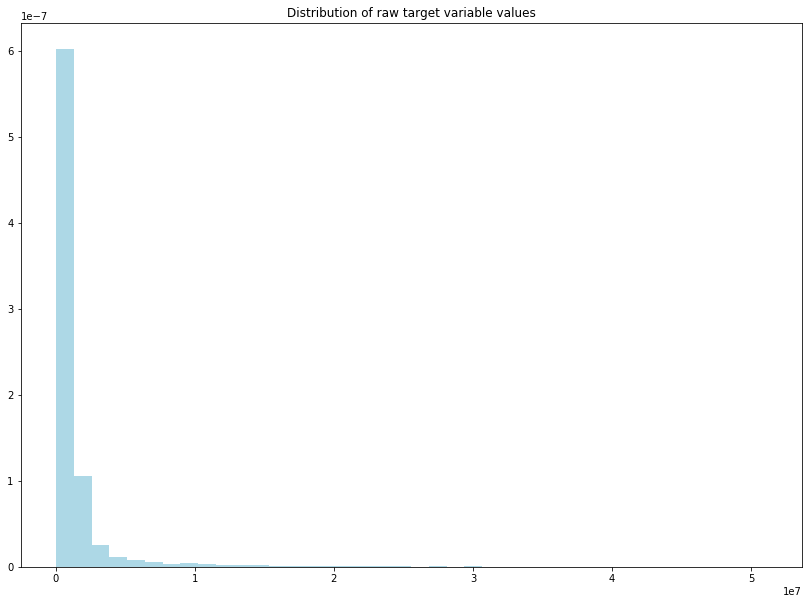

In [29]:
targets = data.map(lambda row: float(row[-1])).collect()

hist(targets, bins=40, color="lightblue", density=True)

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.title('Distribution of raw target variable values')

fig.set_size_inches(14, 10)

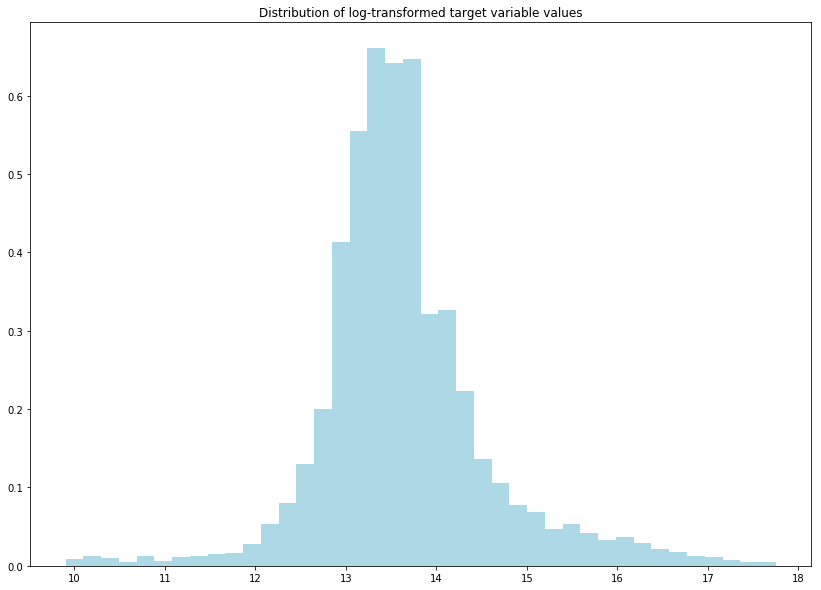

In [30]:

targetsLog = data.map(lambda row: np.log(float(row[-1]))).collect()

hist(targetsLog, bins=40, color="lightblue", density=True)
matplotlib.pyplot.title('Distribution of log-transformed target variable values')

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(14, 10)

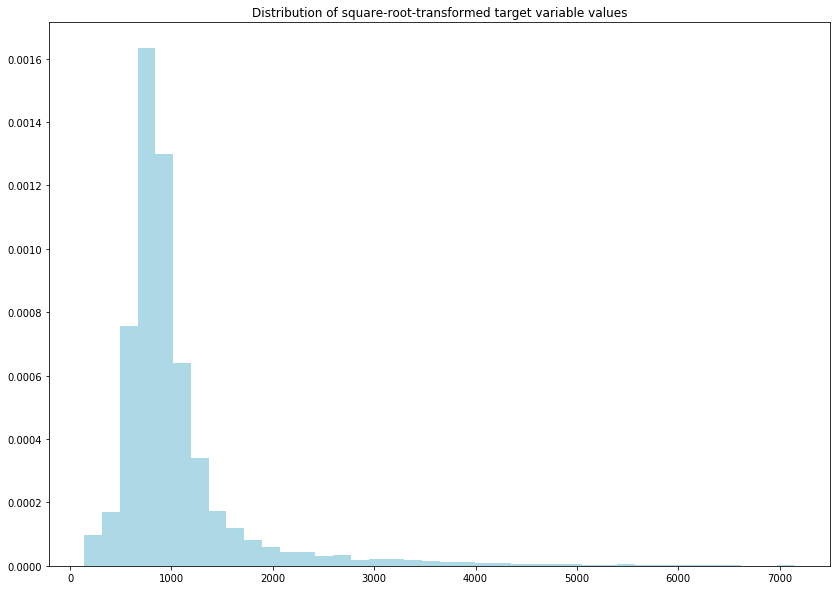

In [31]:

targetsSquare = data.map(lambda row: np.sqrt(float(row[-1]))).collect()

hist(targetsSquare, bins=40, color="lightblue", density=True)

matplotlib.pyplot.title('Distribution of square-root-transformed target variable values')

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(14, 10)

# Log Transformed Targets

In [32]:
dataNewLog = dataNew.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))

modelNewlog = LinearRegressionWithSGD.train(dataNewLog, iterations=10, step=0.1)

predictedVStrueLog = dataNewLog.map(lambda p: (np.exp(p.label), np.exp(modelNewlog.predict(p.features))))

In [33]:
mean_squared_error_log = predictedVStrueLog.map(lambda args: errorSquared(args[0], args[1])).mean()

mean_absolue_error_log = predictedVStrueLog.map(lambda args: errorABS(args[0], args[1])).mean()

root_mean_squared_error_log = np.sqrt(predictedVStrueLog.map(lambda args: errorSquaredLog(args[0], args[1])).mean())


print ("Mean Squared Error For Log Transform: %2.4f" % mean_squared_error_log)

print ("Mean Absolue Error For Log Transform: %2.4f" % mean_absolue_error_log)

print ("Root Mean Squared Log Error For Log Transform: %2.4f" % root_mean_squared_error_log)

print ("Non log-transformed predictions For Log Transform:\n " + str(predictedVStrue.take(3)))

print ("Log-transformed predictions For Log Transform:\n" + str(predictedVStrueLog.take(3)))

Mean Squared Error For Log Transform: 13169474532844.7285
Mean Absolue Error For Log Transform: 1532652.8897
Root Mean Squared Log Error For Log Transform: 13.6695
Non log-transformed predictions For Log Transform:
 [(20000.0, -1.4044691323000699e+82), (20000.0, -9.482533924928922e+81), (21644.0, -9.545428848858508e+81)]
Log-transformed predictions For Log Transform:
[(19999.99999999998, 0.0), (19999.99999999998, 0.0), (21643.999999999996, 0.0)]


# log analysis for Decision tree

In [34]:

dataLogDT = dataNewDT.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))

dataLogDT

dtModelLog = DecisionTree.trainRegressor(dataLogDT,{})

predictionLog = dtModelLog.predict(dataLogDT.map(lambda p: p.features))

actualLog = dataLogDT.map(lambda p: p.label)

predictedVStrueDTLog = actualLog.zip(predictionLog).map(lambda args: (np.exp(args[0]), np.exp(args[1])))

In [35]:
mean_squared_error_log_dt = predictedVStrueDTLog.map(lambda args: errorSquared(args[0], args[1])).mean()

mean_absolue_error_log_dt = predictedVStrueDTLog.map(lambda args: errorABS(args[0], args[1])).mean()

root_mean_squared_error_log_dt = np.sqrt(predictedVStrueDTLog.map(lambda args: errorSquaredLog(args[0], args[1])).mean())

print ("Mean Squared Error For log analysis: %2.4f" % mean_squared_error_log_dt)

print ("Mean Absolue Error For log analysis: %2.4f" % mean_absolue_error_log_dt)

print ("Root Mean Squared Log Error For log analysis: %2.4f" % root_mean_squared_error_log_dt)

print ("Non log-transformed predictions For log analysis:\n" + str(predictedVStrueDT.take(3)))

print ("Log-transformed predictions For log analysis:\n " + str(predictedVStrueDTLog.take(3)))

Mean Squared Error For log analysis: 2295921992202.9414
Mean Absolue Error For log analysis: 250876.0596
Root Mean Squared Log Error For log analysis: 0.1506
Non log-transformed predictions For log analysis:
[(20000.0, 251002.99656946826), (20000.0, 251002.99656946826), (21644.0, 251002.99656946826)]
Log-transformed predictions For log analysis:
 [(19999.99999999998, 109555.94465953598), (19999.99999999998, 109555.94465953598), (21643.999999999996, 109555.94465953598)]


# Gradient Boosted Tree

In [36]:
dataIDx = dataNew.zipWithIndex().map(lambda args: (args[1], args[0]))

test = dataIDx.sample(False, 0.2, 42)

train = dataIDx.subtractByKey(test)

trainData = train.map(lambda args: args[1])

testData = test.map(lambda args: args[1])

trainSize = trainData.count()
testSize = testData.count()

print ("Training data size: %d" % trainSize)

print ("Test data size: %d" % testSize)

print ("Total data size: %d " % (trainSize + testSize))

Training data size: 15201
Test data size: 3849
Total data size: 19050 


# Data Split into training and testing

In [37]:
dataIDxDT = dataNewDT.zipWithIndex().map(lambda args: (args[1], args[0]))

testDT = dataIDxDT.sample(False, 0.2, 42)

trainDT = dataIDxDT.subtractByKey(testDT)

trainDataDT = trainDT.map(lambda args: args[1])

testDataDT = testDT.map(lambda args: args[1])


In [38]:
gradientBoostedTreeModel = GradientBoostedTrees.trainRegressor(dataNewDT,categoricalFeaturesInfo={}, numIterations=3)
gradientBoostedTreeModel

TreeEnsembleModel regressor with 3 trees

In [39]:
predictionsGradient = gradientBoostedTreeModel.predict(dataNewDT.map(lambda p: p.features))

actualGradient = dataNew.map(lambda p: p.label)

predictedVStrueGradient = actualGradient.zip(predictionsGradient)

print ("predictions for Gradient Boosted Tree: " + str(predictedVStrueGradient.take(5)))

print ("Tree depth for Gradient Boosted Tree: " + str(gradientBoostedTreeModel.numTrees()))

print ("number of nodes for Gradient Boosted Tree: " + str(gradientBoostedTreeModel.totalNumNodes()))

## Error rates for Gradient Boosted Trees

mean_squared_error_gradient_dt = predictedVStrueGradient.map(lambda args: errorSquared(args[0], args[1])).mean()

mean_absolute_error_gradient_dt = predictedVStrueGradient.map(lambda args: errorABS(args[0], args[1])).mean()

root_mean_squarede_error_gradient_dt = np.sqrt(predictedVStrueGradient.map(lambda args: errorSquaredLog(args[0], args[1])).mean())

print ("Mean Squared Error - Gradient Boosted Tree: %2.4f" % mean_squared_error_gradient_dt)

print ("Mean Absolute Error - Gradient Boosted Tree: %2.4f" % mean_absolute_error_gradient_dt)

print ("Root Mean Squared Log Error - Gradient Boosted Tree: %2.4f" % root_mean_squarede_error_gradient_dt)

predictions for Gradient Boosted Tree: [(20000.0, 431851.5723081607), (20000.0, 431851.5723081607), (21644.0, 431851.5723081607), (24000.0, 431851.5723081607), (25000.0, 431851.5723081607)]
Tree depth for Gradient Boosted Tree: 3
number of nodes for Gradient Boosted Tree: 45
Mean Squared Error - Gradient Boosted Tree: 2250855625686.1353
Mean Absolute Error - Gradient Boosted Tree: 377869.2208
Root Mean Squared Log Error - Gradient Boosted Tree: 0.4084


# Gradient boost tree iterations

In [40]:
# Gradient boost tree iterations 

def gradientEvaluate(train, test, maxDepth, maxBins):
    gradientModel = GradientBoostedTrees.trainRegressor(
        train, categoricalFeaturesInfo={},
        numIterations=2,
        maxDepth=maxDepth, maxBins=maxBins
    )
    predictionGradient = gradientModel.predict(test.map(lambda p: p.features))
    actualGradient = test.map(lambda p: p.label)
    testPrediction = actualGradient.zip(predictionGradient)
    root_mean_squarede_error = np.sqrt(testPrediction.map(lambda args: errorSquaredLog(args[0], args[1])).mean())
    return root_mean_squarede_error

# Gradient Boosted Tree Depth

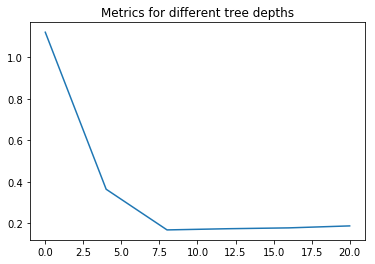

In [41]:
matplotlib.pyplot.title('Metrics for different tree depths')
params = [0, 4, 8, 12, 16, 20]

metrics = [gradientEvaluate(trainDataDT, testDataDT, param, 32) for param in params]

plot(params, metrics)

fig = matplotlib.pyplot.gcf()

# Gradient Boosted Tree Maximum bins

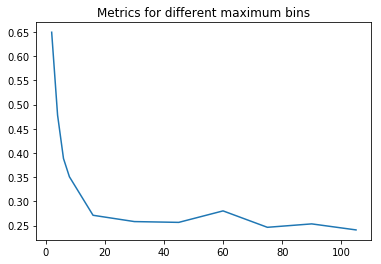

In [42]:
params = [2, 4, 6, 8, 16, 30, 45, 60, 75, 90, 105]

metrics = [gradientEvaluate(trainDataDT, testDataDT, 5, param) for param in params]

plot(params, metrics)

matplotlib.pyplot.title('Metrics for different maximum bins')

fig = matplotlib.pyplot.gcf()


# Linear Models

In [43]:
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    linearModel = LinearRegressionWithSGD.train(
        train, iterations, step, regParam=regParam, 
        regType=regType, intercept=intercept
    )
    predictionLinear = linearModel.predict(test.map(lambda p: p.features))
    actualLinear = test.map(lambda p: p.label)
    testPrediction = actualLinear.zip(predictionLinear)
    rmsle = np.sqrt(testPrediction.map(lambda args: errorSquaredLog(args[0], args[1])).mean())
    return rmsle


# Comparision with diff iterations

D:\spark\spark-2.3.2-bin-hadoop2.7\python\pyspark\statcounter.py:80: RuntimeWarning: invalid value encountered in maximum
  self.maxValue = maximum(self.maxValue, other.maxValue)
D:\spark\spark-2.3.2-bin-hadoop2.7\python\pyspark\statcounter.py:81: RuntimeWarning: invalid value encountered in minimum
  self.minValue = minimum(self.minValue, other.minValue)


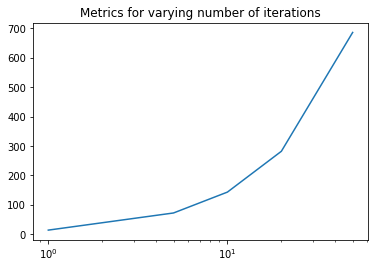

In [44]:
params = [1, 5, 10, 20, 50, 100]

metrics = [evaluate(trainData, testData, param, 0.01, 0.0, "l2", False) for param in params]

plot(params, metrics)

fig = matplotlib.pyplot.gcf()

matplotlib.pyplot.title('Metrics for varying number of iterations')

pyplot.xscale("log")

# Performing same test, changing the step size

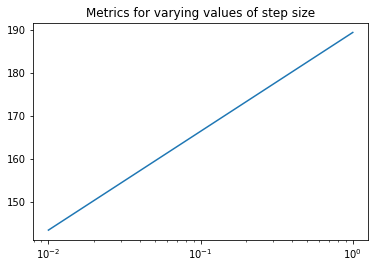

In [45]:
params = [0.01, 0.025, 0.05, 0.1, 1.0]

metrics = [evaluate(trainData, testData, 10, param, 0.0, "l2", False) for param in params]

plot(params, metrics)

fig = matplotlib.pyplot.gcf()

matplotlib.pyplot.title('Metrics for varying values of step size')

pyplot.xscale("log")

# Regularization

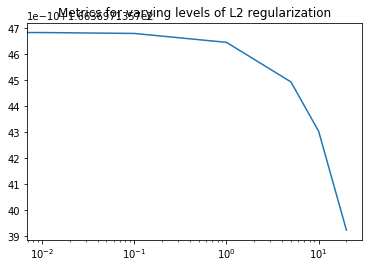

In [46]:

params = [0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]

metrics = [evaluate(trainData, testData, 10, 0.1, param, "l1", False) for param in params]

plot(params, metrics)

matplotlib.pyplot.title('Metrics for varying levels of L2 regularization')

fig = matplotlib.pyplot.gcf()

pyplot.xscale("log")


# Regularization using sparse weight vectors

In [48]:

model_regType11 = LinearRegressionWithSGD.train(trainData, 10, 0.1, regParam=1.0, regType="l1", intercept=False)

model_regType11_regParam10 = LinearRegressionWithSGD.train(trainData, 10, 0.1, regParam=10.0, regType="l1", intercept=False)

model_regType11_regParam100 = LinearRegressionWithSGD.train(trainData, 10, 0.1, regParam=100.0, regType="l1", intercept=False)

print ("number of zero weights regularization: " + str(sum(model_regType11.weights.array == 0)))

print ("number of zeros weights regularization (10): " + str(sum(model_regType11_regParam10.weights.array == 0)))

print ("number of zeros weights regularization (100): " +str(sum(model_regType11_regParam100.weights.array == 0)))

number of zero weights regularization: 0
number of zeros weights regularization (10): 0
number of zeros weights regularization (100): 0


# Intercept

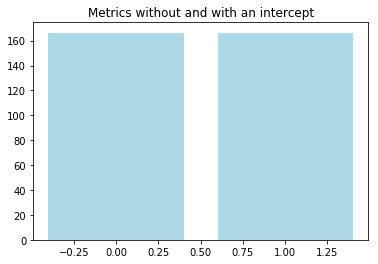

In [49]:

params = [False, True]

metrics = [evaluate(trainData, testData, 10, 0.1, 1.0, "l2", param) for param in params]

bar(params, metrics, color="lightblue")

matplotlib.pyplot.title('Metrics without and with an intercept')

fig = matplotlib.pyplot.gcf()


# impact of parameter on Decision Tree

In [50]:

def evaluateDT(train, test, maxDepth, maxBins):
    modelDT = DecisionTree.trainRegressor(
        train, {}, impurity="variance", 
        maxDepth=maxDepth, 
        maxBins=maxBins
    )
    prediction = modelDT.predict(test.map(lambda p: p.features))
    actual = test.map(lambda p: p.label)
    testPrediction = actual.zip(prediction)
    root_mean_squarede_error = np.sqrt(testPrediction.map(lambda args: errorSquaredLog(args[0], args[1])).mean())
    return root_mean_squarede_error

# Tree Depth

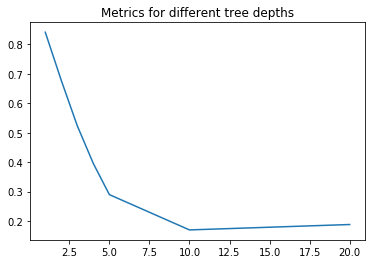

In [51]:

params = [1, 2, 3, 4, 5, 10, 20]

metrics = [evaluateDT(trainDataDT, testDataDT, param, 32) for param in params]

plot(params, metrics)

matplotlib.pyplot.title('Metrics for different tree depths')

fig = matplotlib.pyplot.gcf()


# Maximum bins

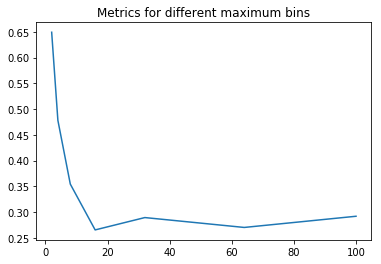

In [52]:

params = [2, 4, 8, 16, 32, 64, 100]

metrics = [evaluateDT(trainDataDT, testDataDT, 5, param) for param in params]

plot(params, metrics)

matplotlib.pyplot.title('Metrics for different maximum bins')

fig = matplotlib.pyplot.gcf()
